In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Library

In [ ]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_4b8939.pth
CHECKPOINT_PATH='/content/weights/sam_vit_l_4b8939.pth'
import torch
from transformers import SamModel
import os
from datasets import Dataset
from PIL import Image
import numpy as np
from patchify import patchify
import cv2
import matplotlib.pyplot as plt
import random
from scipy import ndimage
from torch.utils.data import Dataset

patch_size = 8
step = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_l"
!pip install datasets
!pip install patchify

# Load data


In [ ]:
images_path = ("/content/drive/MyDrive/Wheat head Segmentation Project/SAM/dataset_SAM/100 Images/Train on 100 images")
masks_path=("/content/drive/MyDrive/Wheat head Segmentation Project/SAM/dataset_SAM/100 Images/mask 100")

In [ ]:
def load_images_and_masks(images_path, masks_path , target_size=(256,256)):
    image_files = os.listdir(images_path)
    mask_files = os.listdir(masks_path)
    image_files.sort()
    mask_files.sort()
    images = []
    masks = []

    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(images_path, image_file)
        image = np.array(Image.open(image_path).resize(target_size))
        images.append(image)

        mask_path = os.path.join(masks_path, mask_file)
        mask = np.array(Image.open(mask_path).resize(target_size))
        masks.append(mask)

    return np.array(images), np.array(masks)

train_images, train_masks = load_images_and_masks(images_path, masks_path)




# Preprocess Images


In [ ]:
# Assuming all images are in the same folder
images_path = [os.path.join(images_path, img_name) for img_name in os.listdir(images_path)]

all_img_patches = []
for img_path in images_path:
    large_image = cv2.imread(img_path)
    large_image_gray = cv2.cvtColor(large_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
    patches_img = patchify(large_image_gray, (patch_size, patch_size), step=step)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            single_patch_mask = (single_patch_img / 255.)
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Let's do the same for masks
masks_path = [os.path.join(masks_path, mask_name) for mask_name in os.listdir(masks_path)]

all_mask_patches = []
for mask_path in masks_path:
    large_mask = cv2.imread(mask_path)
    large_mask_gray = cv2.cvtColor(large_mask, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
    patches_mask = patchify(large_mask_gray, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [ ]:
valid_indices = [i for i, mask in enumerate(train_masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = train_images[valid_indices]
filtered_masks = train_masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (100, 256, 256, 3)
Mask shape: (100, 256, 256)


# Convert the NumPy arrays to Pillow images and store them in a dictionary


In [ ]:
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


# Show sample of data

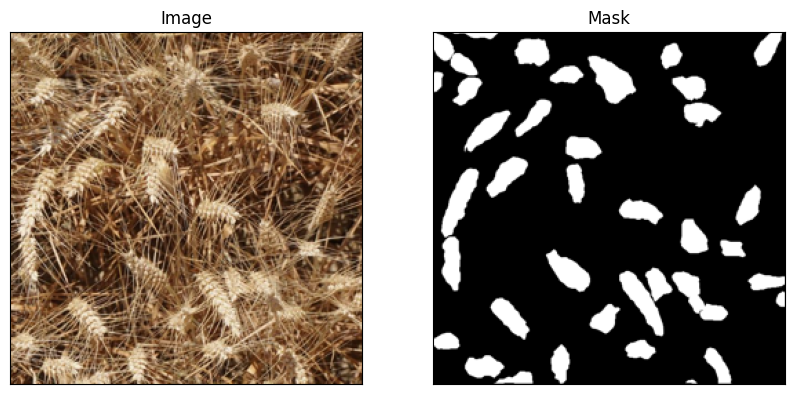

In [ ]:
example_image = dataset[1]["image"]
example_mask = dataset[1]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

 # get bounding box from mask

In [ ]:
def get_bounding_box(ground_truth_map):
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

# Fine Tune SAM model and train it

In [ ]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-large")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.FocalLoss( reduction='mean')

In [ ]:
%cd '/content/drive/MyDrive/Wheat head Segmentation Project/SAM/SAM-VIT-L/weights'

/content/drive/.shortcut-targets-by-id/1Br7pKQHnKasvIwnDj2DecsaHTZb-cvUb/Wheat head Segmentation Project/SAM/SAM-VIT-L/weights


In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

# Define a directory to save the model and logs
save_dir = '/content/drive/MyDrive/Wheat head Segmentation Project/SAM/SAM-VIT-L/run'
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())



    # Print and save training progress
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

    # Save the model state
    model_state_path = os.path.join(save_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.state_dict(), model_state_path)

# Save final model
final_model_path = os.path.join(save_dir, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)


100%|██████████| 50/50 [01:51<00:00,  2.24s/it]


EPOCH: 0
Mean loss: 1.1712958961725235


100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


EPOCH: 1
Mean loss: 0.4669522702693939


100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


EPOCH: 2
Mean loss: 0.33083764523267745


100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


EPOCH: 3
Mean loss: 0.24404413610696793


100%|██████████| 50/50 [01:55<00:00,  2.32s/it]


EPOCH: 4
Mean loss: 0.21809894680976868


100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


EPOCH: 5
Mean loss: 0.19865913897752763


100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


EPOCH: 6
Mean loss: 0.1921863043308258


100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


EPOCH: 7
Mean loss: 0.19467610925436019


100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


EPOCH: 8
Mean loss: 0.18123928636312484


 58%|█████▊    | 29/50 [01:07<00:47,  2.28s/it]